In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt



In [2]:
trybik = cv2.imread('trybik.jpg')
trybik_gray = cv2.cvtColor(trybik, cv2.COLOR_BGR2GRAY)
trybik_gray_not = np.bitwise_not(trybik_gray)
trybik_bin = (trybik_gray_not > 50).astype(np.uint8) * 255


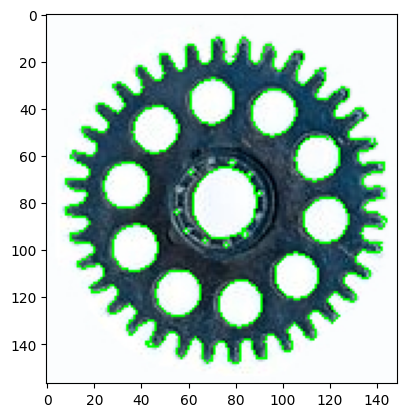

In [3]:
contours, _ = cv2.findContours(trybik_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

sobelX = cv2.Sobel(trybik_gray_not, cv2.CV_64F, 1, 0, ksize=5)
sobelY = cv2.Sobel(trybik_gray_not, cv2.CV_64F, 0, 1, ksize=5)

cv2.drawContours(trybik, contours, -1, (0, 255, 0), 1)
plt.imshow(trybik)

In [4]:
gradient_amplitude = np.sqrt(sobelX**2 + sobelY**2)
gradient_amplitude = gradient_amplitude / np.max(gradient_amplitude)

gradient_orientation = np.rad2deg(np.arctan2(sobelY, sobelX))
gradient_orientation += 180
gradient_orientation = gradient_orientation.astype(np.uint16)

In [5]:
moments = cv2.moments(trybik_bin, 1)

cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])



In [6]:
Rtable = [[] for _ in range(360)]
for point in contours[0]:
    omega = gradient_orientation[point[0][1], point[0][0]]
    r = np.sqrt((point[0][0] - cx)**2 + (point[0][1] - cy)**2)
    beta = np.arctan2(point[0][1] - cy, point[0][0] - cx)
    if omega == 360:
        omega = 0
    Rtable[omega].append((r, beta))
        

In [7]:
trybiki2 = cv2.imread('trybiki2.jpg', cv2.IMREAD_GRAYSCALE)

In [8]:
image = trybiki2
sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

gradient_amplitude = np.sqrt(sobelX**2 + sobelY**2)
gradient_amplitude = gradient_amplitude / np.max(gradient_amplitude)

gradient_orientation =  np.rad2deg(np.arctan2(sobelY, sobelX))
gradient_orientation += 180
gradient_orientation = gradient_orientation.astype(np.uint16)

hough_space = np.zeros((image.shape[0], image.shape[1]))

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        if gradient_amplitude[y, x] > 0.5:
            angle = gradient_orientation[y, x] % 360
            for point in Rtable[angle]:
                x1 = int(point[0] * np.cos(point[1]) + x)
                y1 = int(point[0] * np.sin(point[1]) + y)
                if 0 <= x1 < image.shape[1] and 0 <= y1 < image.shape[0]:
                    hough_space[y1, x1] += 1

            

In [18]:
maxim_y, maxim_x = np.unravel_index(np.argmax(hough_space), hough_space.shape)
sorted_indices = np.argsort(hough_space.flatten())[::-1]

top_indices = sorted_indices[:8]
top_cords = np.unravel_index(top_indices, hough_space.shape)
top_y, top_x = top_cords[0], top_cords[1]

target_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for contour in contours:
    for max_x, max_y in zip(top_x, top_y):
        new_cord = contour[:, 0, :].copy()
        new_cord[:, 0] += max_x - cx
        new_cord[:, 1] += max_y - cy
        cv2.drawContours(target_image, [new_cord], -1, (0, 0, 255), 1)

cv2.imshow("img", target_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

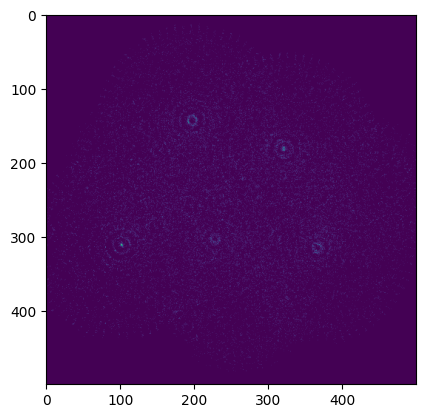

In [13]:
plt.imshow(hough_space)